## IF APPROACH

In [49]:
import findspark
import pandas as pd
findspark.init()

from pyspark.sql import SparkSession
from pyspark import SparkConf


# for shared metastore (shared across all users)
spark = SparkSession.builder.appName("if_approach").config("hive.metastore.uris", "thrift://bialobog:9083", conf=SparkConf()).getOrCreate() \

# for local metastore (your private, invidivual database) add the following config to spark session

spark.catalog.listDatabases()

[Database(name='2023_11_01', description='FactSet data snapshot for 2023_11_01', locationUri='hdfs://amok.cs.ucl.ac.uk:8020/user/hive/warehouse/2023_11_01'),
 Database(name='2023_11_02', description='FactSet data snapshot for 2023_11_02', locationUri='hdfs://amok.cs.ucl.ac.uk:8020/user/hive/warehouse/2023_11_02'),
 Database(name='2023_11_03', description='FactSet data snapshot for 2023_11_03', locationUri='hdfs://amok.cs.ucl.ac.uk:8020/user/hive/warehouse/2023_11_03'),
 Database(name='2023_11_14', description='FactSet data snapshot for 2023_11_14', locationUri='hdfs://amok.cs.ucl.ac.uk:8020/user/hive/warehouse/2023_11_14'),
 Database(name='2023_11_19', description='FactSet data snapshot for 2023_11_19', locationUri='hdfs://amok.cs.ucl.ac.uk:8020/user/hive/warehouse/2023_11_19'),
 Database(name='2023_11_22', description='FactSet data snapshot for 2023_11_22', locationUri='hdfs://amok.cs.ucl.ac.uk:8020/user/hive/warehouse/2023_11_22'),
 Database(name='2024_01_25', description='FactSet da

In [50]:
from pyspark.sql.functions import regexp_replace
from pyspark.sql import functions as F

spark.sql("USE 2023_11_02")
from pyspark.sql.functions import when
from datetime import datetime, timedelta


In [51]:
from pyspark.sql.functions import when
from datetime import datetime, timedelta

import os

curr_dir = os.getcwd()
main_dir = os.path.dirname(curr_dir)
print(main_dir)


/home/ztewari/Stock-Implosion-Prediction-FYP


## Extract Yearly Time Series

In [52]:
from CreateDataset import get_tabular_dataset, get_feature_col_names, get_not_null_cols
import matplotlib.pyplot as plt
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.sql.functions import when, lit, col
# import pyspark.pandas as ps
import numpy as np
from scipy.stats import zscore
import matplotlib.pyplot as plt
import csv
from sklearn.impute import SimpleImputer

def plot_nulls(df):
    null_counts = df.agg(*[
    (1 - (F.count(c) / F.count('*'))).alias(c + '_nulls') for c in df.columns])
    null_counts_pd = null_counts.toPandas().transpose()
    null_counts_pd.columns = ['null_percentage']

    # Plot the bar chart
    # null_counts_pd.plot(kind='bar', legend=False, figsize=(20, 6))
    # plt.title('Percentage of Null Values in Each Column')
    # plt.ylabel('Percentage of Null Values')
    # plt.xlabel('Columns')
    # plt.show()
    
def forward_fill(df):
    window_spec = Window.partitionBy('fsym_id').orderBy('date')
    feature_cols = df.columns[2:-1]
    for c in feature_cols:
        df = df.withColumn(
            c, F.last(c, ignorenulls=True).over(window_spec)
        )
    return df.orderBy('fsym_id','date')

def median_fill(df):
    window_spec = Window.partitionBy('fsym_id').orderBy('date')
    feature_cols = df.columns[2:-1]
    imputer = Imputer(strategy="median", inputCols=feature_cols, outputCols=feature_cols)
    
    
    
    for c in feature_cols:
        median_value = df.approxQuantile(c, [0.5], 0.001)[0]
        df = df.withColumn(
            c, F.when(F.col(c).isNull(), median_value).otherwise(F.col(c))
        )
    return df.orderBy('fsym_id','date')


def get_df(fn, all_feats=False, imploded_only=False, prediction=False):
    df = get_tabular_dataset(fn, all_feats=all_feats, imploded_only=imploded_only, prediction=prediction, null_thresh=0.2) # this returns dataset of yearly time series with 1 if implosion occurred during that year
    
    df =df.toPandas()

    return df

df = get_df(f'{main_dir}/data/imploded_stocks_price.csv', all_feats =True, prediction=False, imploded_only=False)


['ff_assets_com_eq', 'ff_assets_eq', 'ff_assets_gr', 'ff_assets_oth_tot', 'ff_assets_per_emp', 'ff_bps_gr', 'ff_capex_assets', 'ff_capex_ps_cf', 'ff_cash_div_cf', 'ff_cash_roce', 'ff_cf_ps_gr', 'ff_cf_sales', 'ff_com_eq_gr', 'ff_com_eq_tcap', 'ff_debt_com_eq', 'ff_debt_entrpr_val', 'ff_debt_eq', 'ff_debt_lt_cf', 'ff_debt_st_x_curr_port', 'ff_dfd_tax_assets_lt', 'ff_dil_adj', 'ff_div_yld', 'ff_div_yld_secs', 'ff_earn_yld', 'ff_ebit_oper_roa', 'ff_entrpr_val_sales', 'ff_eps_basic_gr', 'ff_fix_assets_com_eq', 'ff_for_assets_pct', 'ff_for_sales_pct', 'ff_free_ps_cf', 'ff_gross_cf_debt', 'ff_inc_adj', 'ff_inc_sund', 'ff_inc_tax_curr', 'ff_inc_tax_dfd', 'ff_int_exp_oth', 'ff_invest_cap', 'ff_invest_lt', 'ff_invest_st_tot', 'ff_ltd_com_eq', 'ff_ltd_tcap', 'ff_min_int_tcap', 'ff_net_cf_debt', 'ff_net_inc_basic_aft_xord', 'ff_net_inc_basic_beft_xord', 'ff_net_inc_bef_xord_gr', 'ff_net_inc_dil', 'ff_net_inc_dil_aft_xord', 'ff_net_inc_per_emp', 'ff_non_oper_exp', 'ff_oper_cf_fix_chrg', 'ff_oper_i

## Feature Selection

### Dropping Highly Correlated Features

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


def correlation_matrix(df):
    # df =df.toPandas()
    print("Converted to Pandas")
    corr_df = df.drop(['date','fsym_id'], axis=1)
    corr_mat = corr_df.corr().abs()
    mask = np.triu(np.ones_like(corr_mat))
    plt.figure(figsize=(50, 40))
    sns.heatmap(corr_mat, annot=True, cmap='coolwarm', fmt=".2f", mask=mask)
    plt.title('Correlation Matrix Heatmap')
    plt.tight_layout()
    plt.savefig('corr_matrix_tab.png')
    plt.close()
    
    print("Variable pairs with absolute correlation above 0.7:")
    corr_dict = {}
    for i in range(len(corr_mat.columns)):
        for j in range(i+1, len(corr_mat.columns)):
            if abs(corr_mat.iloc[i, j]) >= 0.7:
                print(f"{corr_mat.columns[i]} - {corr_mat.columns[j]}: {corr_mat.iloc[i, j]}")
                if corr_mat.columns[i] not in corr_dict.keys():
                    corr_dict[corr_mat.columns[i]] = [corr_mat.columns[j]]
                else:
                    corr_dict[corr_mat.columns[i]].append(corr_mat.columns[j])
                    
    for k,v in corr_dict.items():
        if len(corr_dict[k]) >= 1:
            for col in corr_dict[k]:
                if col in df.columns:
                    df=df.drop(col,axis=1)
    
                

    print(df.columns)
    return df

    
                
df=correlation_matrix(df)

Converted to Pandas
Variable pairs with absolute correlation above 0.7:
ff_assets_com_eq - ff_assets_eq: 0.9978250764422232
ff_assets_com_eq - ff_debt_com_eq: 0.9987191723613513
ff_assets_com_eq - ff_debt_eq: 0.9977479665873509
ff_assets_com_eq - ff_fix_assets_com_eq: 0.7122312115262303
ff_assets_com_eq - ff_ltd_com_eq: 0.9986613816702117
ff_assets_eq - ff_debt_com_eq: 0.9997635827287565
ff_assets_eq - ff_debt_eq: 0.9955327930238194
ff_assets_eq - ff_fix_assets_com_eq: 0.7122673485504473
ff_assets_eq - ff_ltd_com_eq: 0.9997545283319508
ff_assets_gr - ff_com_eq_gr: 0.9999999946425615
ff_assets_gr - ff_debt_lt_cf: 0.998596478816726
ff_assets_gr - ff_debt_st_x_curr_port: 0.9567388654974968
ff_assets_gr - ff_inc_tax_curr: 0.9878313980536448
ff_assets_gr - ff_inc_tax_dfd: 0.9651312315862938
ff_assets_gr - ff_int_exp_oth: 0.9979472092194701
ff_assets_gr - ff_invest_cap: 0.9984958977197079
ff_assets_gr - ff_net_inc_basic_aft_xord: 0.998166217848079
ff_assets_gr - ff_net_inc_basic_beft_xord: 0

### Imputation (Required before Boruta)

In [54]:

feats = df.columns[2:-1]
df[feats] = df.groupby('fsym_id')[feats].transform(lambda x : x.fillna(method='ffill'))
df[feats] = df.groupby('fsym_id')[feats].transform(lambda x: x.fillna(x.median()))


In [56]:
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
# df[feats] = df.groupby(['year'])[feats].transform(lambda x: x.fillna(x.mean()))

In [57]:
df=df.drop('year', axis=1)

In [58]:
feats = df.columns[2:-1]
print(len(feats))

43


In [60]:
df=df.sort_values(by=['fsym_id', 'date'])
df.head()

,fsym_id,date,ff_assets_com_eq,ff_assets_gr,ff_assets_oth_tot,ff_assets_per_emp,ff_bps_gr,ff_capex_assets,ff_cash_div_cf,ff_cash_roce,...,ff_xord,ff_std_debt,ff_tang_assets_debt,ff_bk_oper_inc_oth,ff_commiss_inc_net,ff_cf_roic,ff_liabs_lease,GDP,Unemployment_Rate,label
0,B00FG1-R,2012-12-31,1.248053,7.348883,0.000,10.576109,56.030954,78.273974,0.000000,-32.48987,...,0.0,0.000000,129.518779,0.000000,0.000000,20.792882,0.0,0.006181,7.9,0
1,B00FG1-R,2013-12-31,1.016917,27.333701,0.000,10.576109,56.273777,38.851847,0.000000,-32.48987,...,0.0,0.000000,129.518779,0.000000,0.000000,-32.489870,0.0,0.014049,6.7,0
2,B00FG1-R,2014-12-31,1.016917,1213.345113,2.152,10.576109,-492.849757,11.984993,3321.316445,-32.48987,...,0.0,0.000000,77.245294,-0.294125,0.294125,3.610653,0.0,0.006058,5.6,0
3,B00FG1-R,2015-12-31,1.016917,7.348883,0.000,10.576109,-48.051855,0.483800,186.785493,-32.48987,...,0.0,0.000000,70.526570,-1.071870,1.071870,19.546902,0.0,0.001821,5.0,0
4,B00FG1-R,2016-12-31,1.016917,76.903869,0.000,10.576109,85.114102,2.179701,238.208140,-32.48987,...,0.0,6.938208,130.866314,-0.710952,0.710952,21.835781,0.0,0.010414,4.7,0


'label' here needs to be altered for Approach 1 (Imploding Stock Prediction) - our target variable should be 1 if an implosion occurs after the split_date

In [66]:
split_date = '2018-01-01'
df['date'] = pd.to_datetime(df['date'])
df['target'] = (df['date'] > split_date) & (df['label'] == 1)
df['target'] = df['target'].astype(int)
df = df.drop('label', axis=1)

In [67]:
df.head()

,fsym_id,date,ff_assets_com_eq,ff_assets_gr,ff_assets_oth_tot,ff_assets_per_emp,ff_bps_gr,ff_capex_assets,ff_cash_div_cf,ff_cash_roce,...,ff_xord,ff_std_debt,ff_tang_assets_debt,ff_bk_oper_inc_oth,ff_commiss_inc_net,ff_cf_roic,ff_liabs_lease,GDP,Unemployment_Rate,target
0,B00FG1-R,2012-12-31,1.248053,7.348883,0.000,10.576109,56.030954,78.273974,0.000000,-32.48987,...,0.0,0.000000,129.518779,0.000000,0.000000,20.792882,0.0,0.006181,7.9,0
1,B00FG1-R,2013-12-31,1.016917,27.333701,0.000,10.576109,56.273777,38.851847,0.000000,-32.48987,...,0.0,0.000000,129.518779,0.000000,0.000000,-32.489870,0.0,0.014049,6.7,0
2,B00FG1-R,2014-12-31,1.016917,1213.345113,2.152,10.576109,-492.849757,11.984993,3321.316445,-32.48987,...,0.0,0.000000,77.245294,-0.294125,0.294125,3.610653,0.0,0.006058,5.6,0
3,B00FG1-R,2015-12-31,1.016917,7.348883,0.000,10.576109,-48.051855,0.483800,186.785493,-32.48987,...,0.0,0.000000,70.526570,-1.071870,1.071870,19.546902,0.0,0.001821,5.0,0
4,B00FG1-R,2016-12-31,1.016917,76.903869,0.000,10.576109,85.114102,2.179701,238.208140,-32.48987,...,0.0,6.938208,130.866314,-0.710952,0.710952,21.835781,0.0,0.010414,4.7,0


In [68]:
print(len(df[df['target']==1])) #227 implosions occur after 2018

227


In [70]:
df=df.sort_values(by=['fsym_id', 'date'])
df[df['target']==1].head(100)

,fsym_id,date,ff_assets_com_eq,ff_assets_gr,ff_assets_oth_tot,ff_assets_per_emp,ff_bps_gr,ff_capex_assets,ff_cash_div_cf,ff_cash_roce,...,ff_xord,ff_std_debt,ff_tang_assets_debt,ff_bk_oper_inc_oth,ff_commiss_inc_net,ff_cf_roic,ff_liabs_lease,GDP,Unemployment_Rate,target
110,B06303-R,2021-12-31,1.790217,103.855825,0.124634,0.759305,59.301151,0.000000,0.000000,-22.690069,...,0.0,93.961700,298.695907,0.000000,0.00000,-99.460789,0.040109,0.034648,3.9,1
157,B0CXCV-R,2020-12-31,1.544423,167.621980,0.041000,0.297342,82.302726,0.460218,0.000000,-235.398230,...,0.0,20.203160,1275.282167,0.000000,0.00000,-202.630768,0.039000,0.017409,6.7,1
166,B0P5YF-R,2021-12-31,8.234134,-20.172652,26.216668,0.963226,-93.253691,0.022978,0.000000,-174.766749,...,0.0,0.007499,187.823663,0.000000,0.00000,-14.166641,0.000000,0.034648,3.9,1
424,B1CVR7-R,2021-12-31,6.309471,3.941603,28.264000,0.886197,-12.408341,0.202356,0.000000,-2832.101879,...,0.0,0.234068,71.585731,0.000000,0.00000,-34.765418,1.308000,0.034648,3.9,1
603,B2FJ50-R,2022-06-30,1.804896,22.810442,0.237749,1.662763,-54.755442,1.348571,0.000000,-19.127372,...,0.0,7.469337,1026.259063,0.000000,0.00000,12.305436,0.846871,0.015917,3.5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46561,KKPQ1Q-R,2018-12-31,1.043197,204.025921,0.187456,0.673285,29.582973,0.000000,0.000000,-18.993735,...,0.0,100.000000,14133.103207,-0.146716,-1.06623,-31.319255,0.000000,0.005728,3.9,1
46584,KKVSRH-R,2019-12-31,4.510049,-20.870003,3.802000,0.667600,-80.381666,0.286474,0.000000,-190.143912,...,0.0,85.960248,206.726590,0.000000,0.00000,-130.704825,3.327000,0.009593,3.6,1
47094,KPFSZ5-R,2021-06-30,1.053602,1038.803168,0.000000,1.474094,171.105687,82.544687,0.000000,-0.308273,...,0.0,100.000000,184.984983,0.000000,0.00000,-6.712824,0.000000,0.034648,3.9,1
48080,KV8VNH-R,2019-12-31,1.313164,33.733380,0.308674,1.736800,-81.739626,0.000000,-1.813025,-74.191650,...,0.0,100.000000,1001.029001,0.000000,0.00000,-116.596087,0.000000,0.009593,3.6,1


In [71]:
df.isnull().sum()

fsym_id                     0
date                        0
ff_assets_com_eq          550
ff_assets_gr              190
ff_assets_oth_tot         345
ff_assets_per_emp        5644
ff_bps_gr                 471
ff_capex_assets           888
ff_cash_div_cf            932
ff_cash_roce             1798
ff_cf_ps_gr              3589
ff_cf_sales              5046
ff_com_eq_tcap            104
ff_debt_entrpr_val       1642
ff_dfd_tax_assets_lt        0
ff_dil_adj                124
ff_div_yld               1885
ff_earn_yld              1661
ff_ebit_oper_roa        15014
ff_entrpr_val_sales      6345
ff_for_assets_pct        8368
ff_for_sales_pct         7337
ff_gross_cf_debt         2976
ff_inc_adj                  3
ff_inc_sund                 5
ff_invest_st_tot        12310
ff_ltd_tcap               105
ff_min_int_tcap           117
ff_net_inc_per_emp       5653
ff_non_oper_exp           746
ff_oper_cf_fix_chrg      6071
ff_oper_inc_tcap          117
ff_oper_ps_net_cf        2767
ff_reinves

In [72]:
len(df.columns)

46

### Boruta

In [73]:
from Boruta import BorutaPy
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from collections import Counter


def boruta_fs(train_df, model_name):
    feats = train_df.columns[2:-1]
    train_df['date'] = pd.to_datetime(train_df['date'])
    train_df['year'] = train_df['date'].dt.year
    train_df[feats] = train_df.groupby(['year'])[feats].transform(lambda x: x.fillna(x.mean()))
    train_df=train_df.drop('year', axis=1)
    X_train = train_df.drop(['fsym_id', 'date', 'target'], axis=1)
    y_train = train_df['target']
    
    if model_name == 'rf':
        model = RandomForestClassifier()
    else:
        counter = Counter(y_train)
        estimate = counter[0] / counter[1]
        print('Estimate: %.3f' % estimate)
        model = xgb.XGBClassifier(scale_pos_weight=estimate)
        
    feat_selector = BorutaPy(model, n_estimators='auto', verbose=0, random_state=1)
    feat_selector.fit(X_train, y_train)
    features = X_train.columns.tolist()
    print("Number of features: ", len(features) )
    feature_ranks = list(zip(features, feat_selector.ranking_, feat_selector.support_))
    selected_features = []
    for feat in feature_ranks:
        print(f"Feature: {feat[0]}, Rank: {feat[1]}, Keep: {feat[2]}")
        if feat[1] <= 10:
            selected_features.append(feat[0])
    print("Selected features: ", selected_features)
    return selected_features

rf_feats = boruta_fs(df, 'xgb')
# gbt_feats = boruta_fs(df, 'gbt')

Estimate: 502.031
Number of features:  43
Feature: ff_assets_com_eq, Rank: 13, Keep: False
Feature: ff_assets_gr, Rank: 2, Keep: False
Feature: ff_assets_oth_tot, Rank: 15, Keep: False
Feature: ff_assets_per_emp, Rank: 4, Keep: False
Feature: ff_bps_gr, Rank: 10, Keep: False
Feature: ff_capex_assets, Rank: 14, Keep: False
Feature: ff_cash_div_cf, Rank: 1, Keep: True
Feature: ff_cash_roce, Rank: 26, Keep: False
Feature: ff_cf_ps_gr, Rank: 1, Keep: True
Feature: ff_cf_sales, Rank: 19, Keep: False
Feature: ff_com_eq_tcap, Rank: 24, Keep: False
Feature: ff_debt_entrpr_val, Rank: 6, Keep: False
Feature: ff_dfd_tax_assets_lt, Rank: 12, Keep: False
Feature: ff_dil_adj, Rank: 30, Keep: False
Feature: ff_div_yld, Rank: 1, Keep: True
Feature: ff_earn_yld, Rank: 1, Keep: True
Feature: ff_ebit_oper_roa, Rank: 17, Keep: False
Feature: ff_entrpr_val_sales, Rank: 12, Keep: False
Feature: ff_for_assets_pct, Rank: 3, Keep: False
Feature: ff_for_sales_pct, Rank: 8, Keep: False
Feature: ff_gross_cf_debt,

In [76]:
df = df[rf_feats + ['fsym_id', 'date', 'target']]

In [23]:
# from sklearn.feature_selection import VarianceThreshold

# # Instantiate the VarianceThreshold selector
# selector = VarianceThreshold(2)

# # Fit the selector on the training data
# selector.fit(train_df[feats])

# # Get the indices of the selected features
# selected_indices = selector.get_support(indices=True)

# selected_column_names = train_df[feats].columns[selected_indices]
# print(len(selected_column_names))

In [77]:
print(len(df.columns))

26


In [78]:
df[df['fsym_id'] == 'FL275K-R'].head(10)

,ff_assets_gr,ff_assets_per_emp,ff_bps_gr,ff_cash_div_cf,ff_cf_ps_gr,ff_debt_entrpr_val,ff_div_yld,ff_earn_yld,ff_for_assets_pct,ff_for_sales_pct,...,ff_roic,ff_std_debt,ff_bk_oper_inc_oth,ff_cf_roic,ff_liabs_lease,GDP,Unemployment_Rate,fsym_id,date,target
22188,3.915667,1105.684000,-27.414065,0.000000,-2.080186,0.000000,0.000000,-0.49751,100.0,96.670883,...,-6.255116,11.703026,0.0,-0.694900,0.000,0.014049,6.7,FL275K-R,2013-12-31,0
22189,19.763422,441.401667,-19.592220,0.000000,-2081.825198,1.015300,0.000000,-43.14720,100.0,96.670883,...,-9.681177,3.079076,0.0,-4.180933,0.000,0.006058,5.6,FL275K-R,2014-12-31,0
22190,12.175683,371.359000,-59.210317,0.000000,62.614265,0.979017,0.000000,-241.25400,100.0,96.670883,...,-38.372946,20.638983,0.0,-2.640037,0.000,0.001821,5.0,FL275K-R,2015-12-31,0
22191,4.155076,515.719000,-61.002692,0.000000,43.389674,0.761045,0.000000,-43.96040,100.0,96.670883,...,-8.666151,2.326256,0.0,-3.623490,0.000,0.010414,4.7,FL275K-R,2016-12-31,0
22192,6.221282,273.901667,-3.594035,6.170517,43.389674,0.607287,0.270270,-11.21620,100.0,96.670883,...,-3.844081,6.727019,0.0,1.260335,17.747,0.017494,4.1,FL275K-R,2017-12-31,0
22193,3.676259,283.971000,-1.311792,8.745115,262.344939,0.715345,1.446650,-3.19693,100.0,96.670883,...,-0.809813,16.674250,0.0,4.527186,69.229,0.005728,3.9,FL275K-R,2018-12-31,0
22194,-2.245945,237.937000,-0.129610,18.650227,-47.550046,0.657177,0.941915,10.29580,100.0,96.670883,...,2.887481,13.129146,0.0,2.330664,334.146,0.009593,3.6,FL275K-R,2019-12-31,0
22195,-47.873657,124.027857,-80.033522,-3.339702,-176.783197,0.881003,1.004130,-418.51400,100.0,96.670883,...,-57.857123,10.276906,0.0,-3.250068,351.070,0.017409,6.7,FL275K-R,2020-12-31,0
22196,-7.017087,31.048962,-35.235910,-4.312017,-176.783197,1.243560,1.550390,16.23640,100.0,96.670883,...,2.777742,61.608737,0.0,1.250238,1.825,0.034648,3.9,FL275K-R,2021-12-31,1


### Time Series Feature Extraction

In [79]:
%%capture
import warnings
warnings.filterwarnings("ignore")
import tsfel

def feature_extraction(df):
    df = df.set_index('date')
    df=df.sort_index()
     
    cfg = tsfel.get_features_by_domain(json_path='features3.json')
    
    result_dfs = []
    for fsym_id, group_df in df.groupby('fsym_id'):
        # Exclude 'fsym_id' column from group_df
        # print(group_df.head())
        # non_zero_cols = group_df.columns[(group_df != 0).any()]
        # group_df = group_df[non_zero_cols]

        if not group_df[group_df.index < split_date].empty:
            # try:
            # zero_columns = group_df.columns[(group_df == 0.0).all()].tolist()
            columns_to_drop = ['fsym_id', 'target'] 
            X = tsfel.time_series_features_extractor(cfg, group_df[group_df.index < split_date].drop(columns_to_drop, axis=1), verbose=0)
            X['fsym_id'] = group_df['fsym_id'].iloc[0]
            X['label'] = group_df['target'].sum()
            result_dfs.append(X)
            # except ValueError:
            #     print(f'{fsym_id} received value error')
            #     continue
    
    final_result = pd.concat(result_dfs, ignore_index=True)
    final_result.reset_index(drop=True, inplace=True)
    return final_result

# train_df = feature_extraction(train_df)
# test_df = feature_extraction(test_df)
df = feature_extraction(df)

In [80]:
len(df[df['label']==1])

204

In [82]:
len(df.columns)

1175

In [84]:
df.replace([np.inf, -np.inf], 0.0, inplace=True)

In [85]:
from sklearn.feature_selection import VarianceThreshold

selector = VarianceThreshold(threshold=0.1)
selected_features = selector.fit_transform(df.drop(['fsym_id', 'label'], axis=1))
mask = selector.get_support()
remaining_feats = df.drop(['fsym_id', 'label'], axis=1).columns[mask]
print(remaining_feats)

Index(['GDP_ECDF Percentile Count_0', 'GDP_ECDF Percentile Count_1',
       'GDP_Histogram_4', 'GDP_Histogram_5', 'GDP_Kurtosis',
       'GDP_Negative turning points', 'GDP_Positive turning points',
       'GDP_Signal distance', 'GDP_Skewness', 'GDP_Zero crossing rate',
       ...
       'ff_std_debt_Negative turning points',
       'ff_std_debt_Peak to peak distance',
       'ff_std_debt_Positive turning points', 'ff_std_debt_Root mean square',
       'ff_std_debt_Signal distance', 'ff_std_debt_Skewness',
       'ff_std_debt_Standard deviation', 'ff_std_debt_Sum absolute diff',
       'ff_std_debt_Variance', 'ff_std_debt_Zero crossing rate'],
      dtype='object', length=709)


In [86]:
df = df[remaining_feats.tolist() + ['fsym_id', 'label']]

In [30]:
# null_columns = train_df.columns[train_df.isna().any()].tolist()
# train_df = train_df.drop(null_columns, axis=1)
# test_df = test_df.drop(null_columns, axis=1)

In [87]:
len(df)

8103

In [88]:
df.head()

,GDP_ECDF Percentile Count_0,GDP_ECDF Percentile Count_1,GDP_Histogram_4,GDP_Histogram_5,GDP_Kurtosis,GDP_Negative turning points,GDP_Positive turning points,GDP_Signal distance,GDP_Skewness,GDP_Zero crossing rate,...,ff_std_debt_Positive turning points,ff_std_debt_Root mean square,ff_std_debt_Signal distance,ff_std_debt_Skewness,ff_std_debt_Standard deviation,ff_std_debt_Sum absolute diff,ff_std_debt_Variance,ff_std_debt_Zero crossing rate,fsym_id,label
0,1.0,4.0,0.0,6.0,-1.210520,1.0,1.0,5.000134,0.178896,0.0,...,1.0,2.832512,17.019804,1.788854,2.585717,13.876416,6.685935,2.0,B00FG1-R,0
1,1.0,4.0,0.0,6.0,-1.530316,1.0,1.0,5.000082,-0.099502,0.0,...,1.0,50.373491,135.876759,0.779755,28.788388,135.606654,828.771286,0.0,B01DPB-R,0
2,3.0,14.0,1.0,17.0,5.620490,5.0,4.0,17.001252,-2.249902,2.0,...,1.0,61.903767,310.437726,0.195921,42.904757,304.724437,1840.818195,3.0,B01HWF-R,0
3,2.0,9.0,1.0,11.0,3.762381,4.0,3.0,11.001168,-2.086822,2.0,...,3.0,35.384280,102.896110,-0.546510,8.657516,100.826860,74.952581,0.0,B04CB3-R,0
4,2.0,11.0,1.0,13.0,4.488009,4.0,3.0,13.001179,-2.181407,2.0,...,3.0,58.375932,185.163096,0.456945,39.664549,179.809486,1573.276485,3.0,B04HL7-R,0


In [89]:
df.isnull().sum().nlargest(5)

ff_liabs_lease_Kurtosis       4901
ff_liabs_lease_Skewness       4901
ff_for_assets_pct_Kurtosis    4764
ff_for_assets_pct_Skewness    4764
ff_div_yld_Kurtosis           4410
dtype: int64

In [90]:
null_percentages = (df.isnull().sum() / len(df))
columns_to_drop = null_percentages[null_percentages > 0.2].index
print(len(columns_to_drop))

14


In [91]:
df = df.drop(columns = columns_to_drop)

In [92]:
exclude_cols = ['fsym_id', 'label']
feats = df.drop(exclude_cols, axis=1).columns
feats

Index(['GDP_ECDF Percentile Count_0', 'GDP_ECDF Percentile Count_1',
       'GDP_Histogram_4', 'GDP_Histogram_5', 'GDP_Kurtosis',
       'GDP_Negative turning points', 'GDP_Positive turning points',
       'GDP_Signal distance', 'GDP_Skewness', 'GDP_Zero crossing rate',
       ...
       'ff_std_debt_Negative turning points',
       'ff_std_debt_Peak to peak distance',
       'ff_std_debt_Positive turning points', 'ff_std_debt_Root mean square',
       'ff_std_debt_Signal distance', 'ff_std_debt_Skewness',
       'ff_std_debt_Standard deviation', 'ff_std_debt_Sum absolute diff',
       'ff_std_debt_Variance', 'ff_std_debt_Zero crossing rate'],
      dtype='object', length=695)

In [93]:
from sklearn.preprocessing import StandardScaler

corr_features = tsfel.correlated_features(df[feats])
df.drop(corr_features, axis=1, inplace=True)
# Remove low variance features
# selector = VarianceThreshold()
# train_df = selector.fit_transform(train_df)
# test_df = selector.transform(test_df)

# Normalising Features
# scaler = StandardScaler()
# train_df[feats] = scaler.fit_transform(train_df[feats])
# test_df[feats] = scaler.transform(test_df[feats])

In [94]:
df.isnull().sum()

GDP_ECDF Percentile Count_0                     0
GDP_Histogram_4                                 0
Unemployment_Rate_Average power                 0
Unemployment_Rate_ECDF Percentile Count_0       0
Unemployment_Rate_Interquartile range           0
                                             ... 
ff_std_debt_Signal distance                     0
ff_std_debt_Skewness                         1576
ff_std_debt_Zero crossing rate                  0
fsym_id                                         0
label                                           0
Length: 422, dtype: int64

In [95]:
rows_with_null = df[df.isnull().any(axis=1)]
print(len(rows_with_null))

2441


In [96]:
shuffled_df = df.sample(frac=1, random_state=42)  # Set random_state for reproducibility

# Define the proportion of data for training and testing
train_ratio = 0.8  # 80% of the data for training, change as needed
test_ratio = 1 - train_ratio  # Remaining 20% for testing

# Calculate the number of rows for training and testing
train_size = int(train_ratio * len(df))
test_size = len(df) - train_size

# Split the shuffled DataFrame into training and testing DataFrames
train_df = shuffled_df.head(train_size)
test_df = shuffled_df.tail(test_size)

#### Median Imputation

In [97]:
train_df = train_df.fillna(train_df.median())
test_df = test_df.fillna(test_df.median())

In [98]:
print(len(train_df.columns))
print(len(train_df))
print(len(test_df))
print(len(test_df[test_df['label']==1]))
print(len(train_df[train_df['label']==1]))

422
6482
1621
37
167


In [141]:
import os
import pandas as pd

train_file = 'data_if/train_df_if.csv'
test_file = 'data_if/test_df_if.csv'

# Check if the files exist
if not (os.path.exists(train_file) and os.path.exists(test_file)):
    # Write DataFrames to files
    train_df.to_csv(train_file, index=False)
    test_df.to_csv(test_file, index=False)
else:
    # Read DataFrames from existing files
    print("works")
    train_df = pd.read_csv(train_file, index_col=False)
    test_df = pd.read_csv(test_file, index_col=False)

In [135]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, cross_val_score
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from hyperopt import fmin, tpe, hp
from sklearn import tree

import shap
from sklearn.metrics import classification_report, precision_recall_fscore_support
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import recall_score
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from collections import Counter
from hyperopt.early_stop import no_progress_loss
from functools import reduce
from sklearn.metrics import matthews_corrcoef

def feature_importances(model, features, model_name):
    feature_importances = model.feature_importances_

    sorted_idx = np.argsort(feature_importances)[::-1]  # Sorting in descending order
    top_features = sorted_idx[:20]  # Selecting top 20 features
    top_feature_importances = feature_importances[top_features]
    top_sorted_features = [features[i] for i in top_features]

    plt.figure(figsize=(12, 8))
    plt.bar(range(len(top_features)), top_feature_importances, align="center")
    plt.xticks(range(len(top_features)), top_sorted_features, rotation=45, ha="right")
    plt.xlabel("Feature")
    plt.ylabel("Feature Importance")
    plt.title(f"Top 20 Feature Importances for {model_name}")
    plt.tight_layout()
    plt.savefig(f'results_if2/{model_name}_top20_feature_importances.png')
    plt.show()

    return top_sorted_features

def model_testing(train_df, test_df, classifier):
    seed = 42
    exclude_columns = ['fsym_id', 'label']
    X_train = train_df.drop(exclude_columns, axis=1)
    y_train = train_df['label']
    X_test = test_df.drop(exclude_columns, axis=1)
    y_test = test_df['label']
    
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weight_dict = dict(enumerate(class_weights))
    print(class_weight_dict)
    
    if classifier == 'LogisticRegression':
        param_space = {
            'C': hp.uniform('C', 0.01, 1.0) }
        classifier_instance = LogisticRegression(class_weight = class_weight_dict, solver='sag', random_state=seed) #stochastic average gradient
        scaler = StandardScaler()
        feats = X_train.columns
        X_train[feats] = scaler.fit_transform(X_train[feats])
        X_test[feats] = scaler.transform(X_test[feats])
        
    elif classifier == 'RandomForest':
        param_space = { 
            'n_estimators': hp.quniform('n_estimators', 100, 500, 1),
            'max_depth': hp.quniform('max_depth', 5, 1200, 1),
            'max_features': hp.choice('max_features', [ 'sqrt','log2', None]),
            'min_samples_leaf': hp.uniform('min_samples_leaf', 0, 0.5),
            'min_samples_split' : hp.uniform ('min_samples_split', 0, 1)
        }
        classifier_instance = RandomForestClassifier(class_weight = class_weight_dict, random_state=seed)
    elif classifier == 'XGB':
        param_space = { 'n_estimators':hp.quniform('n_estimators',100,500,1),
                        'max_depth':hp.quniform('max_depth',5,1200,1),
                       'eta': hp.quniform('eta', 0.025, 1, 0.025),
                       'min_child_weight': hp.quniform('min_child_weight', 1, 6, 1),
                        'subsample': hp.quniform('subsample', 0.5, 1, 0.05),
                        'gamma': hp.quniform('gamma', 0.5, 3, 0.05),
                        'colsample_bytree': hp.quniform('colsample_bytree', 0.5, 1, 0.05)
                      }
        counter = Counter(y_train)
        # estimate scale_pos_weight value
        estimate = counter[0] / counter[1]
        print('Estimate: %.3f' % estimate)
        
        classifier_instance = xgb.XGBClassifier(seed=seed)
    else:
        raise ValueError("Unsupported classifier")
    
    def set_params(classifier, params):
        if classifier == 'RandomForest':
            params['max_depth'] = int(params['max_depth'])
            params['n_estimators'] = int(params['n_estimators'])
            # params['min_samples_leaf'] = int(params['min_samples_leaf'])
            # params['min_samples_split'] = int(params['min_samples_split'])
            return params
        elif classifier == 'GBT':
            params['max_depth'] = int(params['max_depth'])
            params['n_estimators'] = int(params['n_estimators'])
            params['min_samples_leaf'] = int(params['min_samples_leaf'])
            params['min_samples_split'] = int(params['min_samples_split'])
            return params
        elif classifier == 'XGB':
            params['max_depth'] = int(params['max_depth'])
            params['n_estimators'] = int(params['n_estimators'])
            # params['min_samples_leaf'] = int(params['min_samples_leaf'])
            # params['min_samples_split'] = int(params['min_samples_split'])
            return params
        
        else:
            return params
    
    obj_scores = []
        
    def objective(params):
        params = set_params(classifier, params)
        classifier_instance.set_params(**params)
        classifier_instance.fit(X_train, y_train)
        # scores = cross_val_score(classifier_instance, X_train, y_train, cv=tscv, scoring='matthews_corrcoef')
        y_pred = classifier_instance.predict(X_test)
        # recall = recall_score(y_test, y_pred)
        score = matthews_corrcoef(y_test, y_pred)
        obj_scores.append(score)
        return -score
        
        
#         scores = cross_val_score(classifier_instance, X_train, y_train, cv=3, scoring='matthews_corrcoef')
#         score = -scores.mean()
#         losses.append(score)
#         return score

    def report_average(*args):
        report_list = list()
        for report in args:
            splited = [' '.join(x.split()) for x in report.split('\n\n')]
            header = [x for x in splited[0].split(' ')]
            data = np.array(splited[1].split(' ')).reshape(-1, len(header) + 1)
            data = np.delete(data, 0, 1).astype(float)
            rest = splited[2].split(' ')
            accuarcy =np.array([0, 0, rest[1], rest[2]]).astype(float).reshape(-1, len(header))
            macro_avg = np.array([rest[5:9]]).astype(float).reshape(-1, len(header))
            weighted_avg = np.array([rest[11:]]).astype(float).reshape(-1, len(header))
            #avg_total = np.array([x for x in avg]).astype(float).reshape(-1, len(header))
            df = pd.DataFrame(np.concatenate((data, accuarcy,macro_avg,weighted_avg)), columns=header)
            report_list.append(df)
        res = reduce(lambda x, y: x.add(y, fill_value=0), report_list) / len(report_list)
        res.to_csv(f'when_{classifier}_results.csv')
        return res.rename(index={res.index[-3]: 'accuracy',res.index[-2]: 'macro_avg',res.index[-1]: 'weighted_avg'})
    
    
    best_params = fmin(fn=objective, space=param_space, algo=tpe.suggest, max_evals=100, early_stop_fn=no_progress_loss(10))
    
#     plt.plot(np.arange(len(l)), losses)
#     plt.xlabel('Iteration')
#     plt.ylabel('Loss')
#     plt.title('Loss during Hyperopt Optimization')
#     plt.show()
    
    best_params = set_params(classifier, best_params)
    classifier_instance.set_params(**best_params)
    
    classifier_instance.fit(X_train, y_train)
    preds = classifier_instance.predict(X_test)
    
    final_report = classification_report(y_test, preds)
    print(final_report)
    mcc = matthews_corrcoef(y_test, preds)
    
    filename = f'results_if2/report_{classifier}_if_pandas'
    existing_mcc = None
    try:
        with open(filename, 'r') as f:
            lines = f.readlines()
            for line in lines:
                if line.startswith('MCC:'):
                    existing_mcc = float(line.split(':')[1])
                    break
    except FileNotFoundError:
        pass

    # Overwriting file only if new MCC is larger
    if existing_mcc is None or mcc > existing_mcc:
        with open(filename, 'w') as f:
            f.write(final_report)
            f.write('\nMCC: ' + str(matthews_corrcoef(y_test, preds)))
            f.write('\nHyperparams: ' + str(best_params))
            
#     test_df['preds'] = preds
    test_df2 = test_df.copy()
    test_df2['preds'] = preds
    
    return classifier_instance, X_train.columns.tolist(), X_train, X_test, test_df2



model, feats, X_train, X_test, full_test_df = model_testing(train_df, test_df, 'XGB')

{0: 0.5132224861441014, 1: 19.407185628742514}
Estimate: 37.814
 32%|███▏      | 32/100 [02:11<04:39,  4.12s/trial, best loss: -0.5114000650820902] 
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1584
           1       0.76      0.35      0.48        37

    accuracy                           0.98      1621
   macro avg       0.87      0.67      0.74      1621
weighted avg       0.98      0.98      0.98      1621



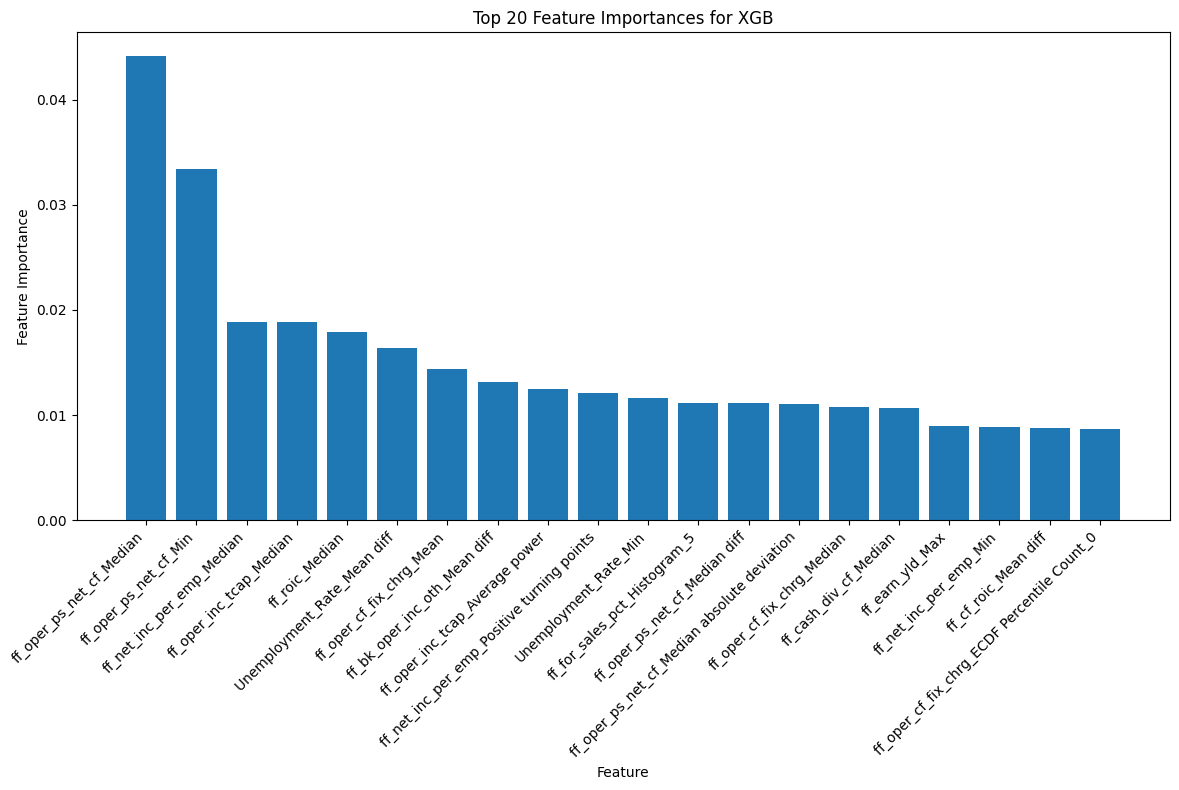

In [136]:
top_feats = feature_importances(model,feats, 'XGB')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


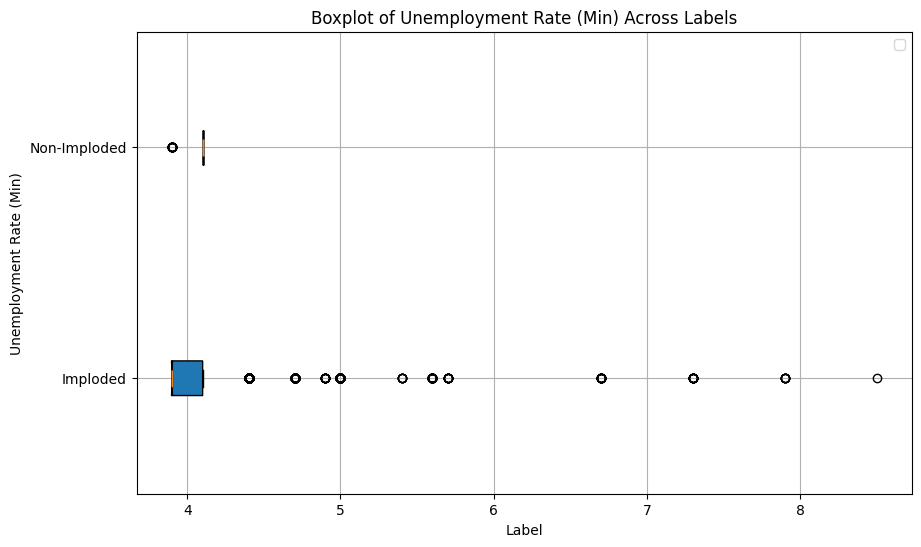

In [137]:
import seaborn as sns

# Assuming 'df' is your DataFrame and 'column_name' is the name of the column you want to plot
plt.figure(figsize=(10, 6))

plt.boxplot([df[df['label'] == 0]['Unemployment_Rate_Min'], 
                df[df['label'] == 1]['Unemployment_Rate_Min']],
                labels=['Imploded', 'Non-Imploded'], vert=False, notch=True, patch_artist=True)

plt.xlabel('Label')  # Label for x-axis
plt.ylabel('Unemployment Rate (Min)')  # Label for y-axis
plt.title('Boxplot of Unemployment Rate (Min) Across Labels')  # Title of the plot
plt.grid(True)  # Show grid
plt.legend()  
# plt.savefig('results_if/unemployment_box_plot_if.png')# Show legend
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


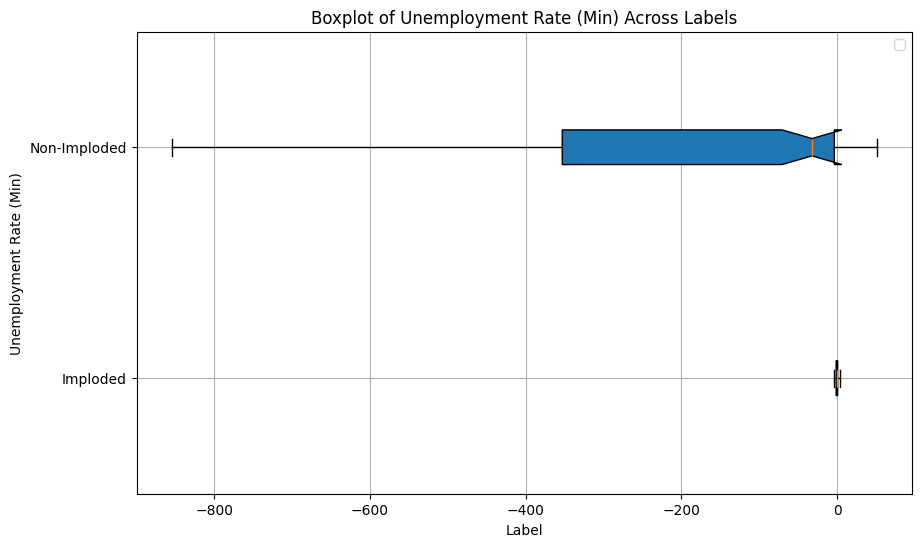

In [138]:
import seaborn as sns

# Assuming 'df' is your DataFrame and 'column_name' is the name of the column you want to plot
plt.figure(figsize=(10, 6))


plt.boxplot([df[df['label'] == 0]['ff_oper_ps_net_cf_Min'], 
                df[df['label'] == 1]['ff_oper_ps_net_cf_Min']],
                labels=['Imploded', 'Non-Imploded'], vert=False, notch=True, patch_artist=True, showfliers=False)

plt.xlabel('Label')  # Label for x-axis
plt.ylabel('Unemployment Rate (Min)')  # Label for y-axis
plt.title('Boxplot of Unemployment Rate (Min) Across Labels')  # Title of the plot
plt.grid(True)  # Show grid
plt.legend()  
# plt.savefig('results_if/unemployment_box_plot_if.png')# Show legend
plt.show()


In [139]:
from hyperopt import hp, fmin, tpe, Trials
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
from hyperopt.early_stop import no_progress_loss
from sklearn.metrics import matthews_corrcoef, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, precision_recall_fscore_support

# Define the search space for hyperparameters

def hyperopt_nn(train_df, test_df):
    exclude_columns = ['fsym_id', 'label']
    feats = train_df.drop(exclude_columns, axis=1).columns.tolist()
    X_train = train_df.drop(exclude_columns, axis=1)
    y_train = train_df['label']
    X_val = test_df.drop(exclude_columns, axis=1)
    y_val = test_df['label']
    
    space = {
        'learning_rate': hp.loguniform('learning_rate', np.log(0.0001), np.log(0.1)),
        'batch_size': hp.choice('batch_size', [1024, 2048, 4096]),
        'num_layers': hp.choice('num_layers', [2, 3, 4, 5, 6]),
        'num_neurons': hp.choice('num_neurons', [128, 256, 512, 1024, 2048, 4096]),
        'dropout_rate': hp.uniform('dropout_rate', 0, 0.5),
        'class_weight_0': hp.uniform('class_weight_0', 0.1, 5),  
        'class_weight_1': hp.uniform('class_weight_1', 0.1, 100) 
    }

    scaler=StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    
    X_train_df = pd.DataFrame(X_train, columns=feats)
    X_val_df = pd.DataFrame(X_val, columns=feats)
    # class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    # class_weight_dict = dict(enumerate(class_weights))
    # print(class_weight_dict)
    
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

    def train_with_params(params):
        model = tf.keras.Sequential()
        model.add(tf.keras.layers.Flatten(input_shape=(X_train.shape[1],)))

        for _ in range(params['num_layers']):
            model.add(tf.keras.layers.Dense(params['num_neurons'], activation='relu'))
            model.add(tf.keras.layers.Dropout(params['dropout_rate']))

        model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

        optimizer = tf.keras.optimizers.Adam(learning_rate=params['learning_rate'])
        model.compile(optimizer=optimizer, loss='binary_crossentropy')

        class_weight_dict = {0: params['class_weight_0'], 1: params['class_weight_1']}
        hist = model.fit(X_train, y_train, batch_size=params['batch_size'], epochs=10, class_weight = class_weight_dict, callbacks = [early_stopping], verbose=0)
        preds = model.predict(X_val, batch_size=params['batch_size'], verbose=0 )
        for i in range(len(preds)):
            preds[i] = 1 if preds[i] >=0.5 else 0
            
        metric = matthews_corrcoef(y_val, preds)
        return model, metric
    
    
    def objective(params):
        model, metric = train_with_params(params)
        return -metric



    # Run hyperparameter optimization
    trials = Trials()
    best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=50, trials=trials, early_stop_fn=no_progress_loss(10))
    
    activation_map = {0: 'relu', 1: 'sigmoid'}
    best_hyperparams = {
        'learning_rate': best['learning_rate'],
        'batch_size': [1024, 2048, 4096, 8192][best['batch_size']],
        'num_layers': [2, 3, 4, 5, 6][best['num_layers']],
        'num_neurons': [128, 256, 512, 1024, 2048][best['num_neurons']],
        'dropout_rate': best['dropout_rate'],
        'class_weight_0': best['class_weight_0'],
        'class_weight_1': best['class_weight_1']
    }

    print("Best hyperparameters:", best_hyperparams)
    best_model, best_metric = train_with_params(best_hyperparams)
    print(f'Best metric: {best_metric}')
    preds = best_model.predict(X_val, batch_size = best_hyperparams['batch_size'])
    print(preds)
    for i in range(len(preds)):
        preds[i] = 1 if preds[i] >= 0.5 else 0
    final_report = classification_report(y_val, preds)
    mcc = matthews_corrcoef(y_val, preds)
    filename = f'results_if2/report_mlp_when'
    existing_mcc = None
    try:
        with open(filename, 'r') as f:
            lines = f.readlines()
            for line in lines:
                if line.startswith('MCC:'):
                    existing_mcc = float(line.split(':')[1])
                    break
    except FileNotFoundError:
        pass

    # Overwriting file only if new MCC is larger
    if existing_mcc is None or mcc > existing_mcc:
        with open(filename, 'w') as f:
            f.write(final_report)
            f.write('\nMCC: ' + str(mcc))
            f.write('\nHyperparams: ' + str(best_hyperparams))
            
    return best_model, X_train_df, X_val_df
    
model, X_train, X_test = hyperopt_nn(train_df, test_df)


 38%|███▊      | 19/50 [03:24<05:33, 10.74s/trial, best loss: -0.3639494358631875]
Best hyperparameters: {'learning_rate': 0.0025978680066557898, 'batch_size': 2048, 'num_layers': 2, 'num_neurons': 512, 'dropout_rate': 0.06694255609555466, 'class_weight_0': 2.515063479604989, 'class_weight_1': 4.3311174228356}
Best metric: 0.1625620694578733
1/1 [==============================] - 0s 23ms/step
[[1.2733500e-02]
 [8.1237175e-02]
 [5.7448801e-06]
 ...
 [3.3594654e-03]
 [8.2577100e-07]
 [2.7276393e-16]]


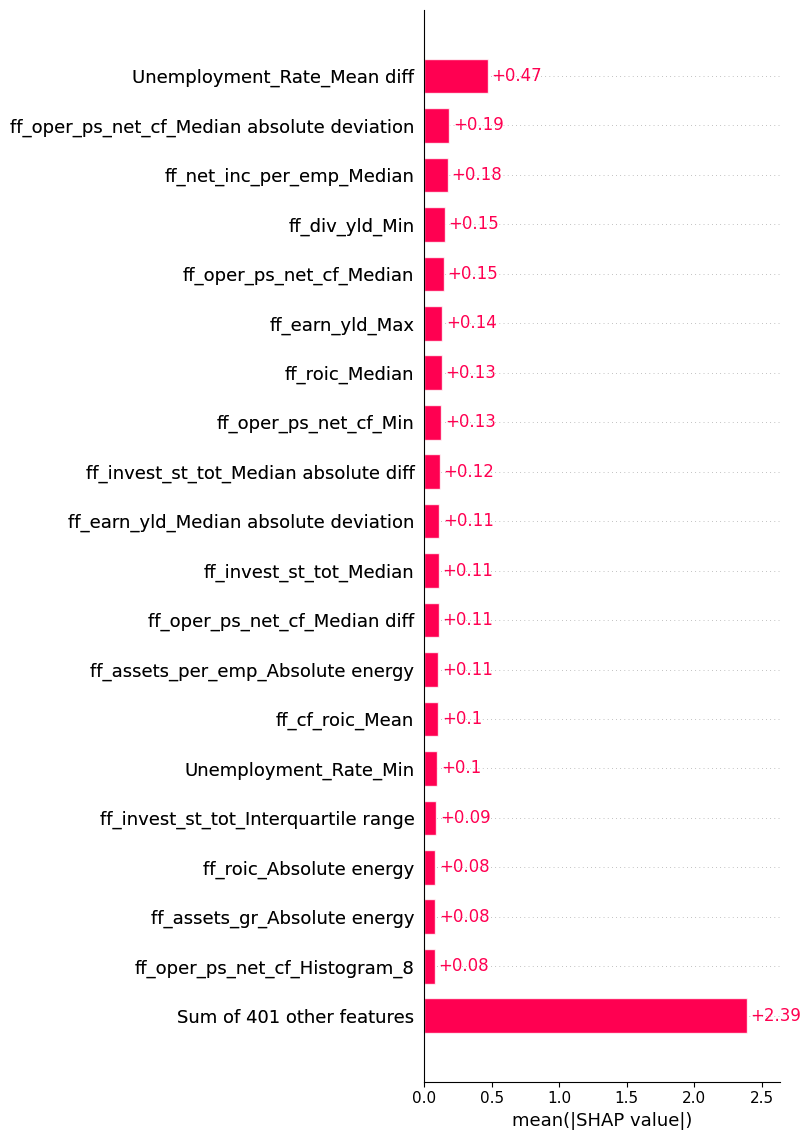

In [127]:
import shap


def shapley(model, train, test, model_name, plot_type):
    # train = train.toPandas()
    # test=test.toPandas()
    # exclude_columns = ['fsym_id',  'label']
    # X_train = train.drop(exclude_columns, axis=1)
    # X_test = test.drop(exclude_columns, axis=1)
    explainer = shap.Explainer(model,train)
    shap_values = explainer(test)
    shap.initjs()
    # print(shap_values.shape)
    # shap.plots.beeswarm(shap_values)
    # shap.summary_plot(shap_values,test,show=False)
    if plot_type == 'bar':
        shap.plots.bar(shap_values, max_display=20, show=False)
    elif plot_type == 'beeswarm':
        shap.plots.beeswarm(shap_values, max_display=20, show=False)
        
    plt.tight_layout()
    plt.savefig(f'results_if2/{model_name}_shap_{plot_type}.png')
    
    
# shapley(model, train_df, test_df, model_name='rf')
    
shapley(model, X_train, X_test, 'XGB', 'bar')

In [38]:
def shapley(model, train, test, feature_names, model_name):
    train_df = pd.DataFrame(train, columns=feature_names)  # Convert train to DataFrame if it's not already
    explainer = shap.DeepExplainer(model, train_df.sample(100))  # Sample from train_df
    shap_values = explainer.shap_values(test)
    shap.initjs()
    shap.summary_plot(shap_values, test, feature_names=feature_names, show=False)
    plt.tight_layout()
    plt.savefig(f'results_if/{model_name}_shap.png')

# feats = train_df.drop(['fsym_id', 'label'], axis=1).columns.tolist()
# shapley(model, X_train, X_test, feats, model_name='MLP')


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
from tensorflow.keras import layers



def plot_model_performance(mdl, loss, metric):
    x = pd.DataFrame(mdl.history).reset_index()
    x = pd.melt(x, id_vars='index')
    x['validation'] = (x['variable'].str[:4] == 'val_').replace({True:'validation',False:'training'})
    x['loss'] = (x['variable'].str[-4:] == 'loss').replace({True:loss,False:metric})
    g = sns.FacetGrid(x, col='loss', hue='validation',sharey=False)
    g.map(sns.lineplot, 'index','value')
    g.add_legend()
    return g

def nn_training(df):
    train_df, test_df = t_t_split(df)

    train_df = train_df.toPandas()
    train_df.replace([np.inf, -np.inf], np.nan, inplace=True)

    # Drop rows containing NaN values
    train_df.dropna(axis=0, how='any', inplace=True)
    
    test_df = test_df.toPandas()
    train_X = train_df.drop(['fsym_id', 'label'], axis=1).values
    train_y = np.array(train_df['label'])
    test_X = test_df.drop(['fsym_id', 'label'], axis=1).values
    test_y = np.array(test_df['label'])
    print(np.sum(test_y==1))
    print(train_X, train_y)
    
    class_labels = np.unique(train_y)
    class_weights = compute_class_weight('balanced', classes=class_labels, y=train_y.flatten())
    class_weight_dict = dict(zip(class_labels, class_weights))
    print(class_weight_dict)
    

    # Define the neural network model
    model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=(train_X.shape[1],)),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),  # Additional Dense layer
        tf.keras.layers.Dropout(0.5),  # Dropout layer for regularization
        tf.keras.layers.Dense(16, activation='relu'),  # Another Dense layer
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    # model = keras.Sequential()
    # model.add(layers.Dense(16,activation="relu",input_shape=(train_X.shape[1],)))
    # model.add(layers.Dense(8,activation="tanh"))
    # model.add(layers.Dense(1))


    # Compile the model
    loss_fn = keras.losses.BinaryCrossentropy()
    optimizer = keras.optimizers.Adam(
        learning_rate=0.001
    )

    
    model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])

    # Train the model
    # early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    fit_model = model.fit(train_X, train_y, epochs=50, batch_size=32, validation_split=0.1, class_weight = class_weight_dict)
    plot_model_performance(fit_model, 'bin_cross_entropy','accuracy')

    # Evaluate the model on the test set
    test_loss, test_acc = model.evaluate(test_X, test_y)
    print(f'Test accuracy: {test_acc}')

    # Make predictions on new data
    predictions = model.predict(test_X)
    for i in range(len(predictions)):
        predictions[i] = 1 if predictions[i] >= 0.5 else 0
    print(classification_report(predictions, test_y.flatten()))
    
    # pred_df = pd.DataFrame()
    # pred_df['prediction'] = predictions
    # pred_df['label'] = test_y
    # confusion_matrix_pandas(pred_df)
    cm = confusion_matrix(test_y, predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
    plt.title(f'Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

nn_training(df)

15
37


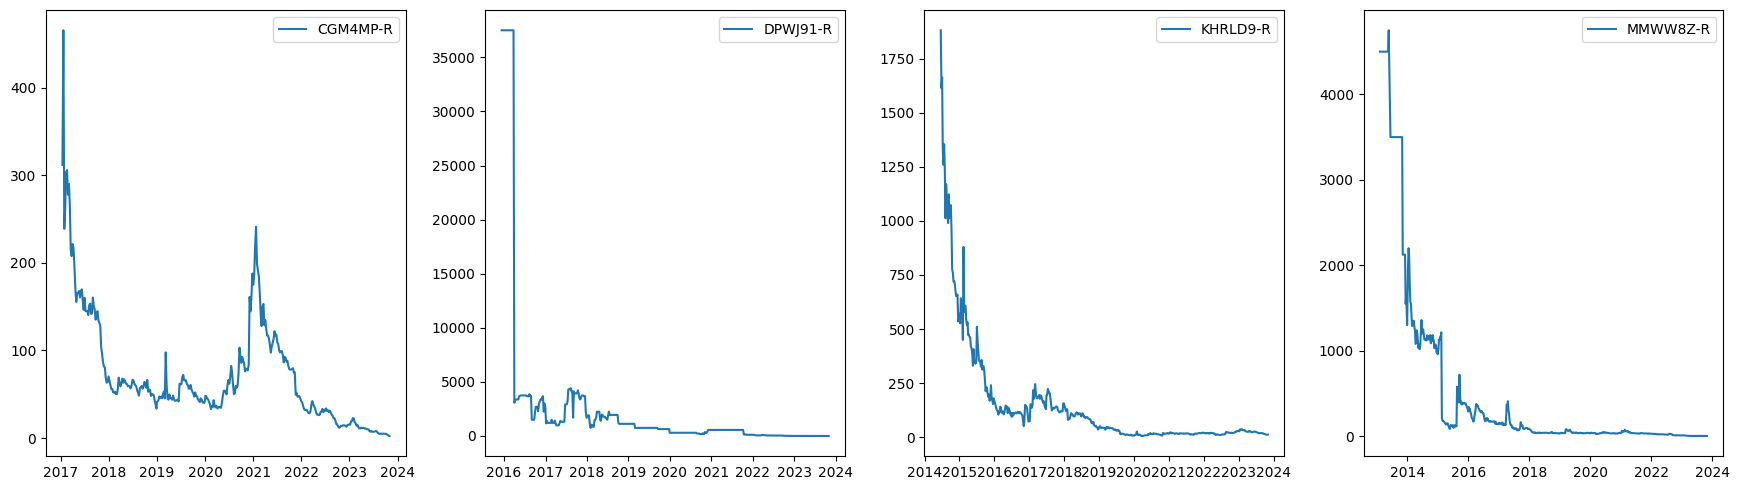

In [130]:
from CreateDataset import get_fund_data
import math

def plotting_stocks_pandas(df):
    imploded_stocks = df[(df['label'] == 0) & (df['preds'] == 1)]
    spark_df = spark.createDataFrame(imploded_stocks['fsym_id'].to_frame())
    imp_prices = get_fund_data(spark_df)
    
    adj_pd = imp_prices.toPandas()
    adj_pd['date'] = pd.to_datetime(adj_pd['date'])
    list_to_plot = sorted(adj_pd['fsym_id'].unique().tolist())
    
    columns = 8
    num_rows = math.ceil(len(list_to_plot) / columns)
    fig, axs = plt.subplots(nrows=num_rows, ncols=columns, figsize=(35, 5*num_rows))
    axs = axs.flatten()
    
    i = 0
    for t in list_to_plot:
        temp_df = adj_pd[adj_pd['fsym_id']==t]
        axs[i].plot(temp_df['date'], temp_df['adj_price'], label=t)

        axs[i].legend()
        #axs[i].text(0.5, -0.1, f'Volatility: {vol:.2f}', ha='center', transform=axs[i].transAxes)
        i+=1
        
    for i in range(len(list_to_plot), num_rows * columns):
        fig.delaxes(axs.flatten()[i])
    
        
    plt.tight_layout()
    plt.savefig('results_if2/incorrect_implosions_detected_by_model_if.png')
    
print(len(full_test_df[full_test_df['preds']==1]))
print(len(full_test_df[full_test_df['label']==1]))
plotting_stocks_pandas(full_test_df) 

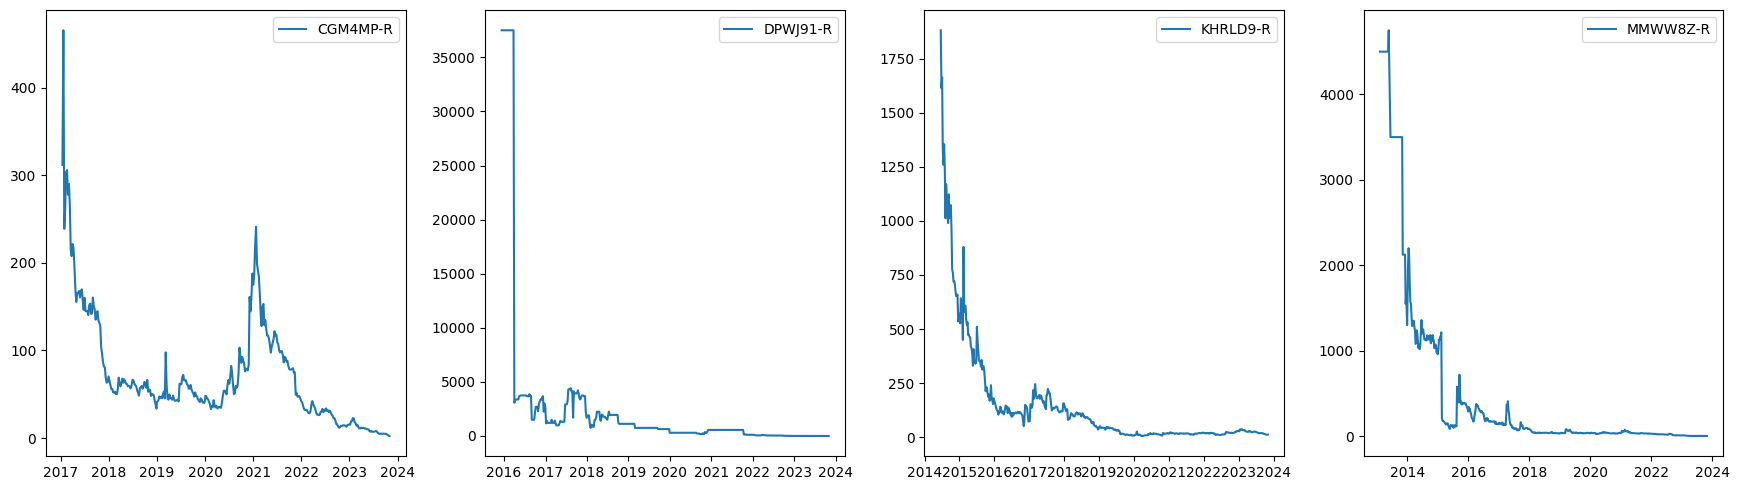### Investigating metrics that changed the most before and after implosions

In [ ]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.sql.functions import when, lit, col
# import pyspark.pandas as ps
import numpy as np
from scipy.stats import zscore
import matplotlib.pyplot as plt
import csv


def pct_change_df(df, big_string, table):
    df=spark.createDataFrame(df)
    df.createOrReplaceTempView("temp_table")
    
    query1 = f"""
                SELECT t.fsym_id, t.Implosion_Start_Date, b.date, {big_string}
                FROM temp_table t
                LEFT JOIN sym_ticker_region s ON s.fsym_id = t.fsym_id
                LEFT JOIN {table} a ON s.fsym_id = a.fsym_id AND  YEAR(a.date) = YEAR(t.Implosion_Start_Date)
                LEFT JOIN {table} b ON s.fsym_id = b.fsym_id AND  YEAR(b.date) = YEAR(t.Implosion_Start_Date)-1
                ORDER BY t.fsym_id
            """
    df1 = spark.sql(query1)
    #print(df1.show())
    df1 = df1.toPandas()
    df1 = df1.drop(['fsym_id','Implosion_Start_Date','date'], axis=1)
    
    def remove_outliers(column):
        Q1 = column.quantile(0.25)
        Q3 = column.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        return column[(column >= lower_bound) & (column <= upper_bound)]



    df1 = df1.abs()
    null_percentage = df1.isnull().sum() / len(df1)
    columns_to_keep = null_percentage[null_percentage <= 0.3].index
    df_nulls_removed = df1[columns_to_keep]
    print("Columns kept: ", len(columns_to_keep)/len(df1.columns))
    
    df_no_outliers = df_nulls_removed.apply(remove_outliers)

    
    column_means_no_outliers = df_no_outliers.mean()
    #column_means_no_outliers = column_means_no_outliers.dropna()
    column_means_no_outliers = column_means_no_outliers.sort_values()
    feats = column_means_no_outliers.tail(5)

    print("Largest averages of differences between previous year and implosion year: ",feats)
    return feats.index.tolist()
    
def avg_change_df(df, big_string, table):
    df=spark.createDataFrame(df)
    df.createOrReplaceTempView("temp_table")
    
    query1 = f"""
                SELECT t.fsym_id, {big_string}
                FROM temp_table t  
                LEFT JOIN sym_ticker_region s ON s.fsym_id = t.fsym_id
                LEFT JOIN {table} a ON s.fsym_id = a.fsym_id AND  YEAR(a.date) > YEAR(t.Implosion_Start_Date)
                LEFT JOIN {table} b ON s.fsym_id = b.fsym_id AND  YEAR(b.date) < YEAR(t.Implosion_Start_Date)
                GROUP BY t.fsym_id
                ORDER BY t.fsym_id
            """
    df1 = spark.sql(query1)
    df1 = df1.toPandas()
    df1 = df1.drop(['fsym_id'], axis=1)
    
    def remove_outliers(column):
        Q1 = column.quantile(0.25)
        Q3 = column.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        return column[(column >= lower_bound) & (column <= upper_bound)]


    df1 = df1.abs()
    null_percentage = df1.isnull().sum() / len(df1)
    columns_to_keep = null_percentage[null_percentage <= 0.3].index
    df_nulls_removed = df1[columns_to_keep]
    print("Columns kept: ", len(columns_to_keep)/len(df1.columns))
    
    df_no_outliers = df_nulls_removed.apply(remove_outliers)
    
    column_means_no_outliers = df_no_outliers.mean()
    #column_means_no_outliers = column_means_no_outliers.dropna()
    column_means_no_outliers = column_means_no_outliers.sort_values()
    feats = column_means_no_outliers.tail(5)
    print("Largest averages of differences in average before and after implosion date: ", feats)
#     for feature in feats.index:
#         before_implosion = df_no_outliers[feature][df_no_outliers.index.isin(df1[df1[feature].notnull() & (df1['date'] < df1['Implosion_Start_Date'])].index)]
#         after_implosion = df_no_outliers[feature][df_no_outliers.index.isin(df1[df1[feature].notnull() & (df1['date'] > df1['Implosion_Start_Date'])].index)]
        
#         _, p_value = ttest_ind(before_implosion, after_implosion)
        
#         print(f"T-test p-value for {feature}: {p_value}")
    return feats.index.tolist()

def t_test():
    pass


def get_metric_changes(filename, table):
    df = pd.read_csv(filename, index_col=False)
    df = df[df['Implosion_Start_Date'].notnull()]
    df['Implosion_Start_Date'] = pd.to_datetime(df['Implosion_Start_Date']).dt.date
    df['Implosion_End_Date'] = pd.to_datetime(df['Implosion_End_Date']).dt.date
    cols = get_not_null_cols(df, table)
    result_string = ', '.join('(a.' + item + '-b.' + item +')/b.'+item + ' AS ' + item for item in cols)
    feats1 = pct_change_df(df, result_string, table) #change 1 year before
    print("Features with greatest percentage change with year before implosion: ", feats1)
    
    result_string2 = ', '.join('(MEAN(a.' + item + ')-MEAN(b.' + item +'))/MEAN(b.'+item + ') AS ' + item for item in cols)
    feats2 = avg_change_df(df, result_string2, table)
    print("Features with greatest percentage change in mean before and after implosion", feats2)
    
    write_features_file( list(set(feats1+feats2)) )


get_metric_changes('imploded_stocks_price.csv', 'FF_ADVANCED_DER_AF')


### Correlations with Market Value Returns

In [ ]:
import csv
from CreateDataset import get_feature_col_names, get_fund_data


def corr_query(implosion_df, col_string, table): 
    df = get_fund_data(implosion_df)
    df=df.withColumn('year', F.year('date'))
    window_spec = Window.partitionBy('fsym_id', 'year').orderBy(col('date').desc())

    df = df.withColumn('row_num', F.row_number().over(window_spec))

    df = df.filter(col('row_num') == 1).orderBy('date') #should we compare correlations with market val?
    #should we do quarterly?
    
    df.createOrReplaceTempView("temp_table")
    query1 = f"""
                SELECT t.fsym_id, t.adj_price, t.Market_Value, t.date, {col_string}
                FROM temp_table t
                LEFT JOIN {table} a ON t.fsym_id = a.fsym_id AND YEAR(t.date)=YEAR(a.date)
                ORDER BY t.fsym_id, t.date
            """
 
    q_df = spark.sql(query1)
    #q_df.show()
    window_spec = Window.partitionBy('fsym_id').orderBy('date')
    
    q_df = q_df.withColumn("return_market_val", (F.col('Market_Value') - F.lag('Market_Value').over(window_spec)) / F.lag('Market_Value').over(window_spec))
    q_df = q_df.withColumn("return", (F.col('adj_price') - F.lag('adj_price').over(window_spec)) / F.lag('adj_price').over(window_spec))
    
    return_columns = [c[2:] for c in col_string.split(", ")]
    mean_corrs = []
    corr_vals = []
    #I THINK U NEED TO GROUP BY DATE AND THEN CALCULATE CORRELATIONS

    for column in return_columns:
        return_col_name = f"return_{column}"
        corr_col_name = f"corr_with_{column}"
        q_df = q_df.withColumn(return_col_name, (F.col(column) - F.lag(column).over(window_spec)) / F.lag(column).over(window_spec))
        q_df = q_df.withColumn(column, F.corr(return_col_name, 'return_market_val').over(window_spec)) #calculating correlations with market value return
        q_df = q_df.drop(*[return_col_name])
    q_df = q_df.drop(*['return_market_val', 'return'])
    q_df = q_df.select(q_df.columns[4:])
    mean_corrs = q_df.agg(*[F.mean(F.abs(F.col(column))).alias(column) for column in q_df.columns])
    # mean_corrs.show()
    
    return mean_corrs.toPandas()

def corr_analysis(table):
    imp_df_price = pd.read_csv('imploded_stocks_price.csv', index_col=False)
    imp_df_price = imp_df_price.loc[imp_df_price['Implosion_Start_Date'].notnull()]
    cols = get_not_null_cols(imp_df_price, 'FF_ADVANCED_DER_AF')
    result_string = ', '.join('a.' + item for item in cols)
    mean_corrs_df = corr_query(spark.createDataFrame(imp_df_price), result_string, 'FF_ADVANCED_DER_AF')
    mean_corrs = mean_corrs_df.to_dict(orient='records')
    sorted_corrs = dict(sorted(mean_corrs[0].items(), key=lambda item: item[1], reverse=True))
    top_records = list(sorted_corrs.items())[:5]
    top_10 = []
    for r in top_records:
        top_10.append(r[0])
    print(top_10)
    current_feature_list = get_feature_col_names()
    new_feature_list = list(set(current_feature_list + top_10))
    
    write_features_file(new_feature_list)
    
    
corr_analysis('FF_Advanced_Der_AF')

### Adding the Extra Features From Literature

In [ ]:
imp_df_price = pd.read_csv('imploded_stocks_price.csv', index_col=False)
imp_df_price['Implosion_Start_Date'] = pd.to_datetime(imp_df_price['Implosion_Start_Date'])
imp_df_price['Implosion_End_Date'] = pd.to_datetime(imp_df_price['Implosion_End_Date'])
available_feats = get_not_null_cols(imp_df_price)
extra_feats = ['ff_capex_assets', 'ff_gross_cf_debt', 'ff_mkt_val_gr']

current_feats = get_feature_col_names()
final_feats = list(set(current_feats + extra_feats))
write_features_file(final_feats)

### Boruta

In [ ]:
def get_df(all_feats=False, imploded_only=False):
    df = get_tabular_dataset(all_feats=all_feats, imploded_only=imploded_only)
    df = forward_fill(df)
    print("Number of rows: ", df.count())
    print("Number of positives: ", df.filter(F.col('label')==1).count())
    df=df.fillna(0.0)
    print("Number of rows after dropping nulls: ", df.count())
    print("Number of positives after dropping nulls: ", df.filter(F.col('label')==1).count())
    return df


def forward_fill(df):
    window_spec = Window.partitionBy('fsym_id').orderBy('date')
    feature_cols = df.columns[2:-1]
    for c in feature_cols:
        df = df.withColumn(
            c, F.last(c, ignorenulls=True).over(window_spec)
        )
    return df.orderBy('fsym_id','date')

df = get_df()


In [ ]:
from Boruta import BorutaPy
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier


def boruta_fs(train_df, model_name): #HOW DOES BORUTA ACC WORK?
    train_df = train_df.toPandas()
    X_train = train_df.drop(['fsym_id', 'date', 'label'], axis=1)
    y_train = train_df['label']
    
    if model_name == 'rf':
        model = RandomForestClassifier()
    else:
        model = GradientBoostingClassifier
    feat_selector = BorutaPy(model, n_estimators='auto', verbose=2, random_state=1)
    feat_selector.fit(X_train, y_train)
    features = X_train.columns.tolist()
    print("Number of features: ", len(features) )
    feature_ranks = list(zip(features, feat_selector.ranking_, feat_selector.support_))
    selected_features = []
    for feat in feature_ranks:
        print(f"Feature: {feat[0]}, Rank: {feat[1]}, Keep: {feat[2]}")
        if feat[1] <= 5:
            selected_features.append(feat[0])
    print("Selected features: ", selected_features)
    return selected_features

rf_feats = boruta_fs(df, 'rf')
gbt_feats = boruta_fs(df, 'gbt')

In [ ]:
# current_features = get_feature_col_names()
# for f in boruta_features:
#     if f in current_features:
#         print(f)
# final_features = list(set(boruta_features + current_features))
# write_features_file(final_features) #in the feature selection pipeline, 

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def correlation_matrix(df):
    df =df.toPandas()
    print("Converted to Pandas")
    corr_df = df.drop(['date','fsym_id'], axis=1)
    corr_mat = corr_df.corr()
    mask = np.triu(np.ones_like(corr_mat))
    plt.figure(figsize=(50, 40))
    sns.heatmap(corr_mat, annot=True, cmap='coolwarm', fmt=".2f", mask=mask)
    plt.title('Correlation Matrix Heatmap')
    plt.tight_layout()
    # plt.savefig('corr_matrix.png')
    plt.close()
    
    print("Variable pairs with absolute correlation above 0.7:")
    for i in range(len(corr_mat.columns)):
        for j in range(i+1, len(corr_mat.columns)):
            if abs(corr_mat.iloc[i, j]) >= 0.7:
                print(f"{corr_mat.columns[i]} - {corr_mat.columns[j]}: {corr_mat.iloc[i, j]}")
                
# correlation_matrix(train_df)

In [ ]:
df = df.drop('ff_div_yld_secs', 'ff_earn_yld', 'ff_roa_ptx', 'ff_net_inc_basic_aft_xord', 'ff_net_inc_dil', 'ff_oper_inc_aft_unusual', 
                        'ff_net_inc_dil_aft_xord', 'ff_net_inc_dil_bef_unusual', 'ff_ebit_bef_unusual', 'ff_eps_dil_gr', 'GDP', 'ff_bk_oper_inc_tot')
feats = df.columns[2:-1]
# write_features_file(feats)
feats

### Extra

In [ ]:
def start_dates(imp_df_price):
    price_data = get_fund_data(spark.createDataFrame(imp_df_price))
    #cols = get_not_null_cols(imp_df_price, 'FF_ADVANCED_DER_AF')
    #result_string = ', '.join('a.' + item for item in cols)
    
    window_spec = Window.partitionBy('fsym_id').orderBy(col('p_date'))

    price_data = price_data.withColumn('row_num', F.row_number().over(window_spec))
    price_data.show()

    price_data = price_data.filter(col('row_num') == 1).orderBy(col('p_date').desc())
    price_data.show()
    
    start_dates = price_data.groupBy('year').count().orderBy('year')
    years = [row['year'] for row in start_dates.collect()]
    counts = [row['count'] for row in start_dates.collect()]
    plt.bar(years, counts)
    plt.xlabel('Year')
    plt.ylabel('Count')
    plt.title('Start Dates Count per Year')
    plt.show()
    #start_dates.show(25)
    
def null_vals(imp_df_price, table):
    price_data = get_fund_data(spark.createDataFrame(imp_df_price))
    cols = get_not_null_cols(imp_df_price, table)
    col_string = ', '.join('a.' + item for item in cols)
    price_data.createOrReplaceTempView('temp_table')
    null_counts = []
    query1 = f"""
                SELECT t.fsym_id, t.split_adj_price, t.Market_Value, t.p_date, {col_string}
                FROM temp_table t
                LEFT JOIN {table} a ON t.fsym_id = a.fsym_id AND YEAR(t.p_date)=YEAR(a.date)
                ORDER BY t.fsym_id, t.p_date
            """
    full_df = spark.sql(query1)
    for column in cols:
        null_count = full_df.select(column).filter(col(column).isNull()).count()
        null_counts.append((column, null_count))
    null_counts_df = pd.DataFrame(null_counts, columns=['Column', 'Null Count'])
    plt.figure(figsize=(10, 6))
    plt.bar(null_counts_df['Column'], null_counts_df['Null Count'])
    plt.xlabel('Column')
    plt.ylabel('Null Count')
    plt.title('Null Counts for Each Column')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    # null_counts = price_data.groupBy('year').agg(F.sum(col('p_price').isNull().cast('int')).alias('null_count'))
    # null_counts.show()
    
imp_df_price = pd.read_csv('imploded_stocks_price.csv', index_col=False)
imp_df_price_imploded = imp_df_price.loc[imp_df_price['Implosion_Start_Date'].notnull()]
start_dates(imp_df_price)
start_dates(imp_df_price_imploded)

#null_vals(imp_df_price, 'FF_ADVANCED_DER_AF')

In [ ]:
imp_df_price = pd.read_csv('imploded_stocks_price.csv', index_col=False)
imp_df_test = imp_df_price[imp_df_price['fsym_id']=='H7CTYF-R']
df = get_fund_data(spark.createDataFrame(imp_df_test))
df.show(1000)
imp_df_imp = imp_df_price[imp_df_price['Implosion_Start_Date'].notnull()]
print(len(imp_df_imp))

In [ ]:
imp_df_imp = imp_df_price[imp_df_price['Implosion_Start_Date'].notnull()]
print(len(imp_df_imp))
print(len(imp_df_price))

In [ ]:
def get_cols():
    df_metrics = ps.DataFrame(spark.sql("SELECT * FROM FF_BASIC_AF LIMIT 10")) #get all the metrics
    cols = []
    for c in df_metrics.columns:
        if df_metrics[c].dtype=='float64':#get all the metrics we can calculate correlations with
            cols.append(c)
    return cols

#%change average of each feature plotted for pharmacy industry
def industry_analysis():
    stock_df = get_all_stocks_df()
    #stock_df = pd.read_csv('imploded_stocks.csv')
    #stock_df = spark.createDataFrame(stock_df)
    cols = ['ff_gross_inc', 'ff_sales', 'FF_OPER_EXP_TOT', 'FF_CASH_ST']
    col_string = ', '.join('a.' + item for item in cols)
    stock_df.createOrReplaceTempView("temp_table")
    q = f"""SELECT e.factset_industry_desc, t.ticker_region, a.date, {col_string} FROM temp_table t
    LEFT JOIN FF_BASIC_AF a ON a.fsym_id = t.fsym_id
    LEFT JOIN sym_coverage sc ON sc.fsym_id = t.fsym_id
    LEFT JOIN ff_sec_entity_hist c on c.fsym_id=sc.fsym_security_id
    LEFT JOIN sym_entity_sector d on d.factset_entity_id=c.factset_entity_id
    LEFT JOIN factset_industry_map e on e.factset_industry_code=d.industry_code
    WHERE a.date >= "2009-01-01" AND e.factset_industry_desc="Regional Banks"
    ORDER BY t.ticker_region,a.date"""
    ind_df = spark.sql(q)
    #print(ind_df.show(10))
    ind_df =ind_df.toPandas()
    ind_df['date'] = pd.to_datetime(ind_df['date'])
    new_cols = []
    for column in cols:
        ind_df[f'{column}_percentage_change'] = ind_df.groupby('ticker_region')[column].pct_change() * 100
        ind_df[f'{column}_percentage_change'].replace([np.inf, -np.inf], np.nan, inplace=True)
        ind_df.drop(column, axis=1, inplace=True)
        new_cols.append(f'{column}_percentage_change')
    ind_df['year'] = ind_df['date'].dt.year
    avg_pct_change = ind_df.groupby(['year'])[new_cols].mean().reset_index()
    print(avg_pct_change.head(20))
    num_rows = (len(new_cols) + 1) // 2  # Adjust the number of rows as needed
    num_cols = 2
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
    for i,column in enumerate(new_cols):
        row = i//num_cols
        col = i % num_cols 
        axes[row,col].plot(avg_pct_change['year'], avg_pct_change[column])
        axes[row, col].set_title(f'Avg {column} Percentage Change Over Time')
        axes[row, col].set_xlabel('Year')
        axes[row, col].set_ylabel(f'Avg {column} Percentage Change')
        axes[row, col].grid(True)
    plt.tight_layout()
    plt.show()

#industry_analysis()

In [ ]:

#YOU'VE DONE WORST CHANGES NOW FIND OUT WHICH ONES DECREASE CONSISTENTLY
#ALSO FIGURE OUT MEANS BEFORE PERIOD AND AFTER PERIOD USING QUARTERLY AND COMPARE DIFF
#FINALLY WITH A HUGE LIST USE BORUTA

In [ ]:
def get_not_null_cols(df, table='FF_ADVANCED_DER_AF'):
    df=spark.createDataFrame(df)
    df.createOrReplaceTempView("temp_table")
    query1 = f"""SELECT t.fsym_id, a.*
                FROM temp_table t
                LEFT JOIN {table} a ON t.fsym_id = a.fsym_id
                ORDER BY t.fsym_id, a.date
            """
    #we get all the available dates per stock, so these null values are only within the timeframe available
    q_df = spark.sql(query1)
    column_types = q_df.dtypes
    null_pcts = []
    for c, dtype in zip(q_df.columns, column_types):
        if dtype[1] == 'double':
            null_count = q_df.filter(F.col(c).isNull()).count()
            null_pcts.append(null_count/q_df.count())


    columns_to_drop = [col_name for col_name, null_pct, dtype in zip(q_df.columns, null_pcts, column_types) if null_pct > 0.2 or dtype[1]!='double']

    q_df = q_df.drop(*columns_to_drop)

    cols = q_df.columns
    print(cols)

    return cols
    
df = pd.read_csv('imploded_stocks_price.csv', index_col=False)
df = df.loc[df['Implosion_Start_Date'].notnull()]
get_not_null_cols(df)

In [ ]:
spark.stop()

## spark version of training

In [ ]:
from hyperopt import fmin, tpe, hp
import csv
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from itertools import chain
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql.functions import udf
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, CrossValidatorModel
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from hyperopt.early_stop import no_progress_loss
from sklearn.metrics import matthews_corrcoef



def feature_importances(model, features, name):
    feature_importances = model.featureImportances.toArray()
    

    top_features_idx = np.argsort(feature_importances)[-25:]  # Get the indices of the top 25 features
    sorted_features = [features[i] for i in top_features_idx]


    plt.figure(figsize=(20, 6))
    plt.bar(range(len(sorted_features)), feature_importances[top_features_idx], align="center")
    plt.xticks(range(len(sorted_features)), sorted_features, rotation=45, ha="right")
    plt.xlabel("Feature")
    plt.ylabel("Feature Importance")
    plt.title("Feature Importances")
    plt.savefig(f'{name}_if_feats.png', bbox_inches='tight')
    return sorted_features
    
    
def model_training_spark(train_df, test_df, classifier):
    
    features = train_df.drop('fsym_id', 'label').columns
        
    def compute_weights(train_df):
        y_collect = train_df.select("label").groupBy("label").count().collect()
        unique_y = [x["label"] for x in y_collect]
        total_y = sum([x["count"] for x in y_collect])
        unique_y_count = len(y_collect)
        bin_count = [x["count"] for x in y_collect]

        class_weights_spark = {i: ii for i, ii in zip(unique_y, total_y / (unique_y_count * np.array(bin_count)))}
        print(class_weights_spark)
        mapping_expr = F.create_map([F.lit(x) for x in chain(*class_weights_spark.items())])
        train_df = train_df.withColumn("weight", mapping_expr.getItem(F.col("label")))
        return train_df
        
    train_df = compute_weights(train_df)
    
    vector_assembler = VectorAssembler(inputCols=features, outputCol="features_vector")
    train_df = vector_assembler.transform(train_df)
    test_df = vector_assembler.transform(test_df)

    if classifier == 'LogisticRegression':
        param_space = {
            'regParam': hp.uniform('regParam', 0.01, 1.0),
            'elasticNetParam': hp.uniform('elasticNetParam', 0.0, 1.0)
        }
        classifier_instance = LogisticRegression(featuresCol="features_vector", labelCol="label", weightCol='weight')
    elif classifier == 'RandomForest':
        param_space = {
            'maxBins': hp.quniform('maxBins', 16, 256, 1),
            'maxDepth': hp.quniform('maxDepth', 20, 30, 1)
        }
        classifier_instance = RandomForestClassifier(featuresCol='features_vector', labelCol='label', weightCol='weight')
    elif classifier == 'GBT':
        param_space = {
            'maxDepth' : hp.quniform("maxDepth", 20, 30, 1),
            'maxBins': hp.quniform('maxBins', 16, 128, 1)
        }
        classifier_instance = GBTClassifier(featuresCol='features_vector', labelCol='label')
    else:
        raise ValueError("Unsupported classifier")
    
    # initial_model = classifier_instance
    # initial_model = initial_model.fit(train_df)
    def mcc(truth, preds):
        truth = truth.toPandas()
        preds = preds.toPandas()
        metric = matthews_corrcoef(truth, preds)
        return metric

    def cross_val_train(params):
        classifier_instance.setParams(**params)
        # evaluator = BinaryClassificationEvaluator(metricName='areaUnderROC')
        # train, val = train_df.randomSplit([0.9,0.1])
        # curr_model = classifier_instance.fit(train)
        # predictions = curr_model.transform(val)
        # val_metric = evaluator.evaluate(predictions)
        # return curr_model, val_metric
        # paramGrid = ParamGridBuilder().build()
        # crossval = CrossValidator(estimator=classifier_instance,
        #                           estimatorParamMaps=paramGrid,
        #                           evaluator=evaluator,
        #                           numFolds=5, parallelism=12)
        
        cv_model = classifier_instance.fit(train_df)
        predictions = cv_model.transform(test_df)
        val_metric = mcc(predictions.select('label'), predictions.select('prediction'))
        
        return cv_model, val_metric
    
    
    def objective(params):
        model, metric = cross_val_train(params)
        return -metric

    # Find the best hyperparameters
    best_params = fmin(fn=objective, space=param_space, algo=tpe.suggest, max_evals=50, early_stop_fn=no_progress_loss(10))
    print("Best hyperparameters: ", best_params)

    # Train the model with the best hyperparameters
    best_model, final_metric = cross_val_train(best_params)
            
    
    predictions = best_model.transform(test_df)
    true = predictions.select('label').toPandas()
    preds = predictions.select('prediction').toPandas()
    print(classification_report(true, preds))
    print("MCC: ", matthews_corrcoef(true, preds))
    
    with open(f'if_{classifier}.txt', 'w') as f:
        f.write(classification_report(true, preds))
        f.write(f"\n\nMatthews Correlation Coefficient: {matthews_corrcoef(true, preds)}")
    
    cm = confusion_matrix(true, preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", linewidths=.5)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()
    
    return best_model, train_df,  predictions


# model, train_df_done, pred_df = model_training_spark(train_df2, test_df2, 'GBT')